# hw3: Обучение без учителя

*Спасибо ещё одному великому курсу mlcourse.ai и авторам: Ольга Дайховская (@aiho в Slack ODS), Юрий Кашницкий (@yorko в Slack ODS).*

### О задании

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в
задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице.

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации.

**Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы, выделив ответ полужирным** (``` **выделить двойными звёздочками** ```).

### Оценивание и штрафы
Вам необходимо ответить на 10 вопросов и выполнить 2 задания. Каждое из заданий и вопросов имеет определенную «стоимость» (указана в скобках). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw3-unsupervised.ipynb``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце "hw3" в строке со своей фамилией о том, что вы выполнили работу и оставить ссылку на ноутбук.


In [1]:
%pip install seaborn
%pip install ipywidgets

In [45]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [3]:
X_train = np.loadtxt("X_train.txt")
y_train = np.loadtxt("y_train.txt").astype(int)

X_test = np.loadtxt("X_test.txt")
y_test = np.loadtxt("y_test.txt").astype(int)

In [4]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*.

In [5]:
# Ваш код здесь
X = np.vstack([X_train, X_test])
y = np.hstack([y_train, y_test])

Определим число уникальных значений меток целевого класса.

In [6]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [7]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

*уж простите, если звучание этих существительных кажется корявым :)*

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [8]:
# Ваш код здесь
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [9]:
# Ваш код здесь
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

**Вопрос 1:** (1 балл)

Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

**Варианты:**
- 56
- **65**
- 66
- 193

In [10]:
# Ваш код здесь
print(f"Количество компонент для 90% дисперсии: {pca.n_components_}")

Количество компонент для 90% дисперсии: 65


**Вопрос 2:** (0.5 баллов)

Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов.

**Варианты:**
- 45
- **51**
- 56
- 61

In [11]:
# Ваш код здесь
first_component_variance = round(pca.explained_variance_ratio_[0] * 100)
print(f"Процент дисперсии первой компоненты: {first_component_variance}%")

Процент дисперсии первой компоненты: 51%


Визуализируйте данные в проекции на первые две главные компоненты.

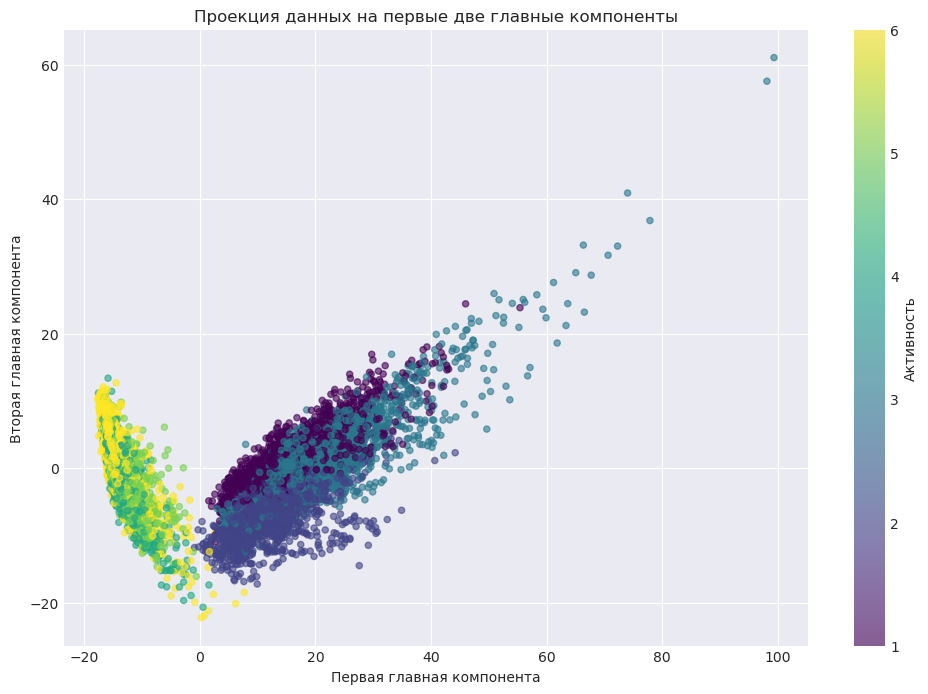

In [12]:
# Ваш код здесь
plt.figure(figsize=(12, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap='viridis', alpha=0.6)
plt.colorbar(label='Активность')
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.title('Проекция данных на первые две главные компоненты')
plt.show()

**Вопрос 3:** (0.5 баллов)

Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- **2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)**
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 6 кластеров

------------------------------

**Задание 1.** (1 балл)

Сделайте кластеризацию данных методом `KMeans` (собственная имплементация и готовая реализация), обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [14]:
# Ваш код здесь
kmeans = KMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE)
kmeans.fit(X_pca)
cluster_labels = kmeans.labels_

Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

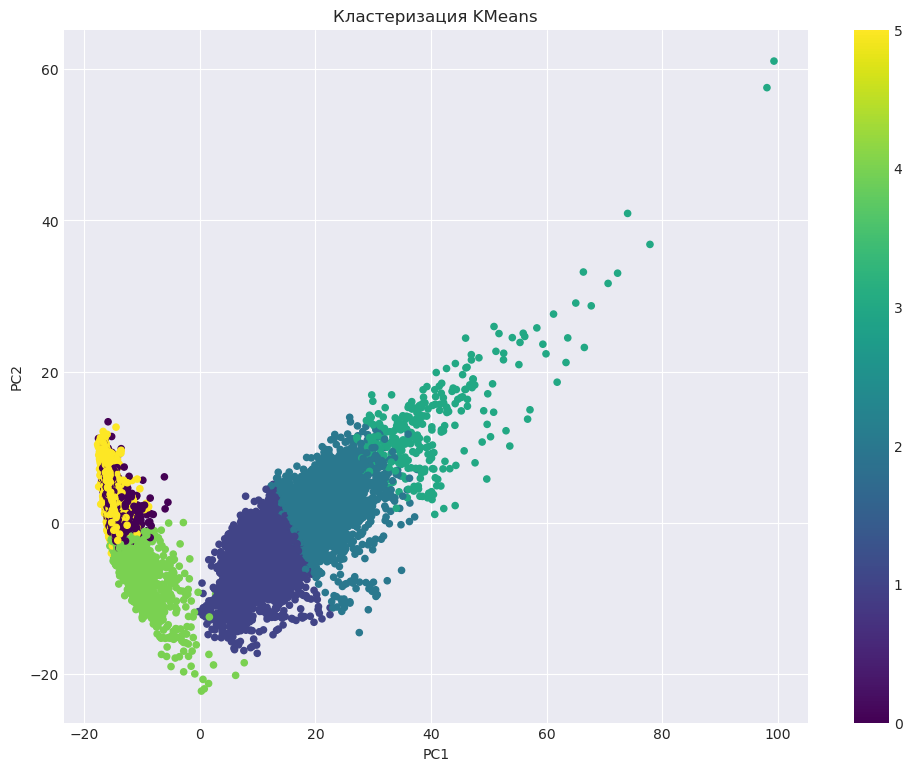

In [15]:
# Ваш код здесь
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=20, cmap='viridis')
plt.title("Кластеризация KMeans")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar()
plt.show()

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [30]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице',
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
print(tab)
max_ratios = {}
for i in range(1, 7):
    class_data = tab.iloc[i-1, :-1]
    max_ratio = class_data.max() / class_data.sum()
    max_ratios[tab.index[i-1]] = max_ratio
    print(f"{tab.index[i-1]}: {max_ratio:.3f}")

best_separated = max(max_ratios, key=max_ratios.get)
print(f"\nЛучше всего отделилась активность: {best_separated}")

                          cluster1  cluster2  cluster3  cluster4  cluster5  \
ходьба                           0       903       741        78         0   
подъем вверх по лестнице         0      1241       296         5         2   
спуск по лестнице                0       320       890       196         0   
сидение                       1235         1         0         0       450   
стояние                       1344         0         0         0       562   
лежание                         52         5         0         0       329   
все                           2631      2470      1927       279      1343   

                          cluster6    все  
ходьба                           0   1722  
подъем вверх по лестнице         0   1544  
спуск по лестнице                0   1406  
сидение                         91   1777  
стояние                          0   1906  
лежание                       1558   1944  
все                           1649  10299  
ходьба: 0.524
подъем вв

Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации.

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,

то такая доля будет 900 / 1406 $\approx$ 0.64.


**Вопрос 4:** (1 балл)

Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- стояние
- спуск по лестнице
- **перечисленные варианты не подходят**

Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

<ipython-input-17-8767275d55ba>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(1, n_classes + 1)):
/lib/python3.13/site-packages/tqdm/__init__.py:28: TqdmMonitorWarning: tqdm:disabling monitor support (monitor_interval = 0) due to:
can't start new thread
  return _tqdm_notebook(*args, **kwargs)


  0%|          | 0/6 [00:00<?, ?it/s]

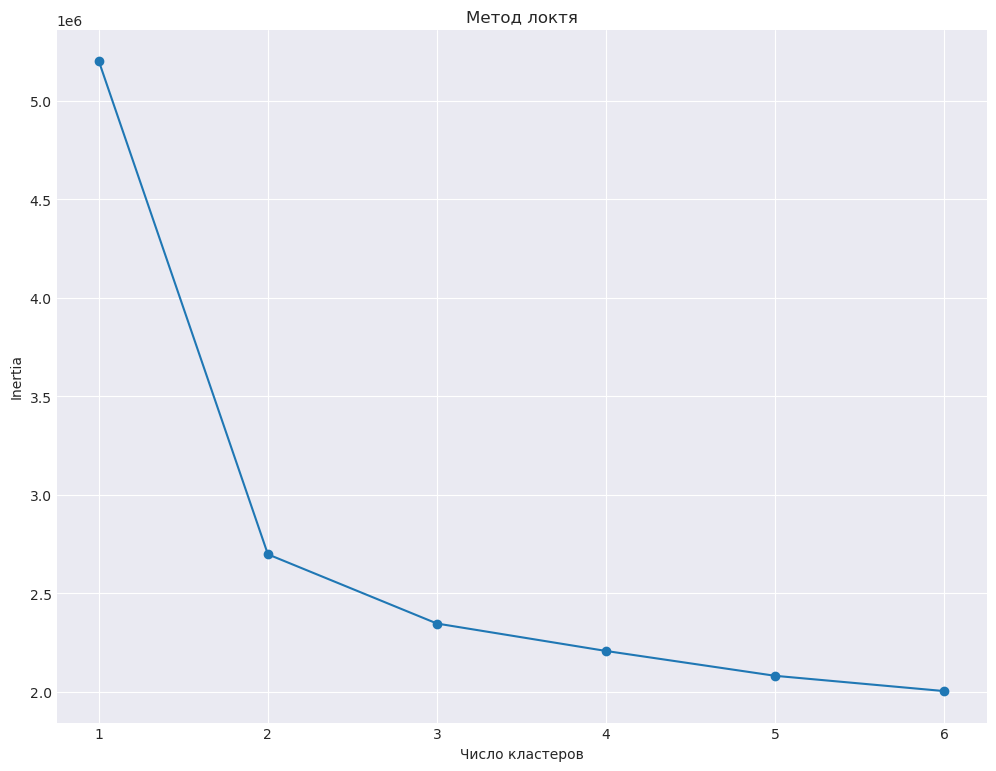

In [17]:
# Ваш код здесь
inertia = []
for k in tqdm_notebook(range(1, n_classes + 1)):
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, n_classes + 1), inertia, marker='o')
plt.xlabel('Число кластеров')
plt.ylabel('Inertia')
plt.title('Метод локтя')
plt.show()

**Вопрос 5:** (1 балл)

Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- **2**
- 3
- 4

------------------------

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [18]:
ag = AgglomerativeClustering(n_clusters=n_classes,
                             linkage='ward').fit(X_pca)

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [21]:
# Ваш код здесь
ari_kmeans = metrics.adjusted_rand_score(y, cluster_labels)
ari_ag = metrics.adjusted_rand_score(y, ag.labels_)

print(f"ARI для KMeans: {ari_kmeans:.3f}")
print(f"ARI для Agglomerative Clustering: {ari_ag:.3f}")

ARI для KMeans: 0.420
ARI для Agglomerative Clustering: 0.494


**Вопрос 6:** (1 балл)

Отметьте все верные утверждения.<br>

**Варианты:**
- **Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering**
- **Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры**
- **В случае случайного разбиения на кластеры ARI будет близок к нулю**

-------------------------------

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf).

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`.

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), прмиените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [22]:
# Ваш код здесь
scaler_svc = StandardScaler()
X_train_scaled = scaler_svc.fit_transform(X_train)
X_test_scaled = scaler_svc.transform(X_test)

In [23]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [24]:
# Ваш код здесь
grid_search = GridSearchCV(svc, svc_params, cv=3, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
best_svc = grid_search.best_estimator_

/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [25]:
# Ваш код здесь
print("Лучший параметр C:", grid_search.best_params_)
print("Лучшая точность на кросс-валидации: {:.3f}".format(grid_search.best_score_))

Лучший параметр C: {'C': 0.1}
Лучшая точность на кросс-валидации: 0.938


**Вопрос 7** (0.5 баллов)

Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.001
- 0.01
- **0.1**
- 1
- 10

In [26]:
y_predicted = best_svc.predict(X_test_scaled)

In [39]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице',
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
print(tab)
print("\n")

# Рассчитываем точность и полноту для каждого класса вручную
activities = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице',
              'сидение', 'стояние', 'лежание']

print("Метрики для каждой активности:")
print(f"{'Активность':<30} {'Точность':<15} {'Полнота':<15}")

precision_scores = {}
recall_scores = {}

for activity in activities:
    recall = tab.loc[activity, activity] / tab.loc[activity, 'все']
    precision = tab.loc[activity, activity] / tab.loc['все', activity]
    precision_scores[activity] = precision
    recall_scores[activity] = recall
    print(f"{activity:<30} {precision:.4f} ({precision*100:.2f}%)  {recall:.4f} ({recall*100:.2f}%)")


worst_precision = min(precision_scores, key=precision_scores.get)
worst_recall = min(recall_scores, key=recall_scores.get)

print(f"\nХуже всего определяется:")
print(f"  По точности: {worst_precision} ({precision_scores[worst_precision]*100:.2f}%)")
print(f"  По полноте: {worst_recall} ({recall_scores[worst_recall]*100:.2f}%)")

                          ходьба  подъем вверх по лестнице  спуск по лестнице  \
ходьба                       494                         2                  0   
подъем вверх по лестнице      12                       459                  0   
спуск по лестнице              2                         4                413   
сидение                        0                         4                  0   
стояние                        0                         0                  0   
лежание                        0                         0                  0   
все                          508                       469                413   

                          сидение  стояние  лежание   все  
ходьба                          0        0        0   496  
подъем вверх по лестнице        0        0        0   471  
спуск по лестнице               1        0        0   420  
сидение                       426       61        0   491  
стояние                        15      517        0

**Вопрос 8:** (0.5 балл)

Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Ответ:**
- по точности – подъем вверх по лестнице, по полноте – лежание
- по точности – лежание, по полноте – сидение
- по точности – ходьба, по полноте – ходьба
- **по точности – сидение, по полноте – стояние**

Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

**Вопрос 9:** (1 балл)

Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Варианты:**
- Качество одинаковое
- 2%
- **4%**
- 10%
- 20%


In [40]:
pca_svc = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_train_pca = pca_svc.fit_transform(X_train_scaled)
X_test_pca = pca_svc.transform(X_test_scaled)

grid_search_pca = GridSearchCV(svc, svc_params, cv=3, n_jobs=-1)
grid_search_pca.fit(X_train_pca, y_train)
best_svc_pca = grid_search_pca.best_estimator_

print("Лучший параметр C (PCA):", grid_search_pca.best_params_)
print("Лучшая точность на кросс-валидации (PCA): {:.3f}".format(grid_search_pca.best_score_))

diff = abs(grid_search.best_score_ - grid_search_pca.best_score_) * 100
print("Разница в точности: {:.1f}%".format(diff))

Лучший параметр C (PCA): {'C': 0.1}
Лучшая точность на кросс-валидации (PCA): 0.898
Разница в точности: 4.0%


**Вопрос 10:** (1 балл)

Выберите все верные утверждения:

**Варианты:**
- Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
- **PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность**
- **PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком**

**Задание 2.** (1 балл)

Попробуйте использовать DBSCAN в качестве алгоритма кластеризации и метод понижения размерности tSNE.

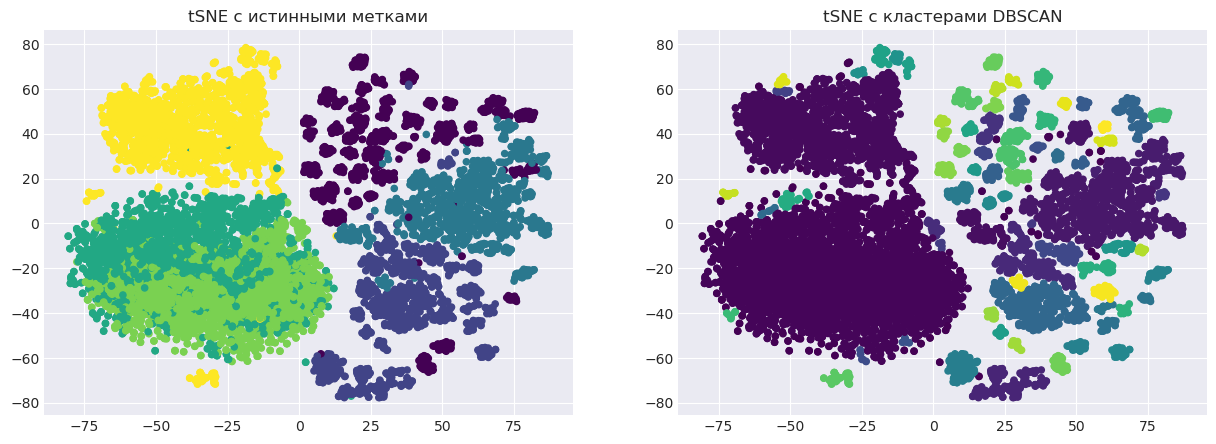

Число кластеров DBSCAN: 78
Число шумовых точек: 164


In [46]:
tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

dbscan = DBSCAN(eps=2.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_tsne)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, s=20, cmap='viridis')
plt.title("tSNE с истинными метками")

plt.subplot(1, 2, 2)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=dbscan_labels, s=20, cmap='viridis')
plt.title("tSNE с кластерами DBSCAN")
plt.show()

print("Число кластеров DBSCAN:", len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0))
print("Число шумовых точек:", list(dbscan_labels).count(-1))